# Imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import erf 
import lmfit # source: https://lmfit.github.io/lmfit-py/
from lmfit import minimize, Parameters, fit_report
from tqdm import tqdm
import multiprocessing
from astropy.timeseries import LombScargle
import os
import time
np.random.seed(110)

# Création d'une raie

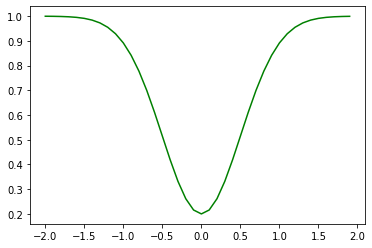

In [2]:
def Gauss(x, a, sigma):
        return 1 - a * np.exp(-x**2 / (2 * sigma**2))


def skewed_gaussian(x, a, sigma, alpha) :
    def cdf(x) :
        return((1/2)*(1+erf(x/np.sqrt(2))))

    return 1 + (2/sigma)*(-a/2)*np.exp(-(x)**2 / (2 * sigma**2))*cdf(alpha*(x)/sigma)


a0 = 0.8
sigma_0 = 0.5

x = np.arange(-2,2,1/10) 
Template = Gauss(x, a0, sigma_0)

plt.plot(x, Template, "g")
plt.show()

# Contamination

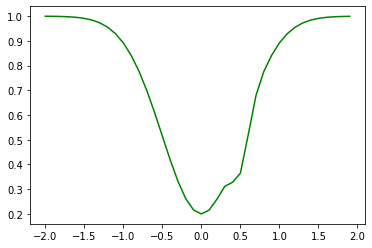

In [10]:
a0 = 0.15
sigma_0 = 0.1

x = np.arange(-2,2,1/10) 
conta = Template + Gauss(x-0.5, a0, sigma_0) - 1

plt.plot(x, conta, "g")
plt.show()

# Difference

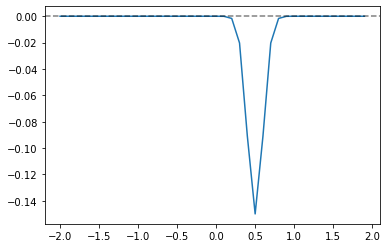

In [11]:
# Plot difference
plt.plot(x, conta - Template)
plt.axhline(0,c='k', linestyle='--', alpha=0.5)
plt.show()

According the Bouchy's framework (Bouchy et al. 2001; Artigau et al. 2022):

$A(i)-A_0(i) = d_{temp} + dv \frac{d A_0(i)}{d \lambda(i)} + d_{LW} \frac{d^2 A_0(i)}{d \lambda(i)^2} + d³v \frac{d^3 A_0(i)}{d \lambda(i)^3} + \mathcal{O}(\frac{d^3 A_0(i)}{d \lambda(i)^3}) $

# lets then fit the bouchy equation to find $d_{temp}$, $dv$, $d_{LW}$ and $d³v$

In [12]:
d1 = np.gradient(Template, x)
d2 = np.gradient(d1, x)
d3 = np.gradient(d2, x)
diff_seg = conta-Template

def equation(params, d1, d2, d3, diff):
    d0v = params.get('d0v').value
    dv  = params.get('dv').value
    d2v = params.get('d2v').value
    d3v = params.get('d3v').value
    zero = d0v + dv*d1 + d2v*d2 + d3v*d3 - diff
    return(zero)

#initialize
params_ini = Parameters()
params_ini.add('d0v', value=0, min=-np.inf, max=np.inf)
params_ini.add('dv', value=0, min=-np.inf, max=np.inf)
params_ini.add('d2v', value=0, min=-np.inf, max=np.inf)
params_ini.add('d3v', value=0, min=-np.inf, max=np.inf)
#fit
out = minimize(equation, params_ini, args = (d1, d2, d3, diff_seg))

#result
d0v = out.params['d0v'].value
dv = out.params['dv'].value
d2v = out.params['d2v'].value
d3v = out.params['d3v'].value

sd0v = out.params['d0v'].stderr
sdv = out.params['dv'].stderr
sd2v = out.params['d2v'].stderr
sd3v = out.params['d3v'].stderr

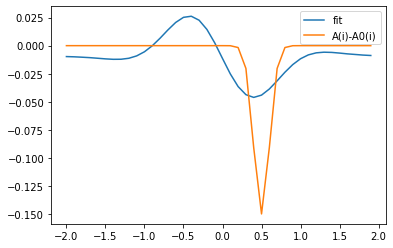

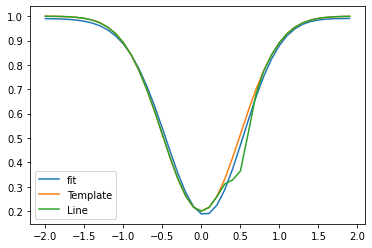

In [14]:
plt.plot(x, equation(out.params, d1, d2, d3, diff_seg)+diff_seg, label='fit')
plt.plot(x, diff_seg, label='A(i)-A0(i)')
plt.legend()
plt.show()

plt.plot(x, equation(out.params, d1, d2, d3, diff_seg)+diff_seg+Template, label='fit')
plt.plot(x, Template, label='Template')
plt.plot(x, conta, label='Line')
plt.legend()
plt.show()

In [15]:
print('d0v = ', d0v, ' +/- ', sd0v)
print('dv  = ', dv, ' +/- ', sdv)
print('d2v = ', d2v, ' +/- ', sd2v)
print('d3v = ', d3v, ' +/- ', sd3v)

d0v =  -0.009393880393285217  +/-  0.004076527912673495
dv  =  -0.015880261983533425  +/-  0.012469818006554152
d2v =  -0.0006623225835107686  +/-  0.003230178053769791
d3v =  0.002661981018888004  +/-  0.0017076682164490133


# Moving telluric

In [112]:
times = np.linspace(0, 1000, 1000) 
xoff_serie = 1.5 * np.sin(times*2*np.pi/365.25)

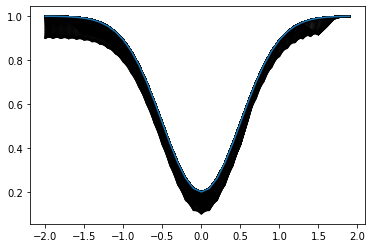

In [113]:
d0v, dv, d2v, d3v     = np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times))
sd0v, sdv, sd2v, sd3v = np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times)), np.zeros(len(times))

for i in range(len(times)):
    #generate line 
    a0 = 0.075
    sigma_0 = 0.1
    line = Template + Gauss(x+xoff_serie[i], a0, sigma_0) - 1
    a0 = 0.1
    sigma_0 = 0.15
    line = line + Gauss(x+xoff_serie[i]+1, a0, sigma_0) - 1
    plt.plot(x, line, 'k', alpha=0.2)
    #fit
    out = minimize(equation, params_ini, args = (d1, d2, d3, line-Template))
    
    d0v[i] = out.params['d0v'].value
    dv[i]  = out.params['dv'].value
    d2v[i] = out.params['d2v'].value
    d3v[i] = out.params['d3v'].value

    sd0v[i] = out.params['d0v'].stderr
    sdv[i]  = out.params['dv'].stderr
    sd2v[i] = out.params['d2v'].stderr
    sd3v[i] = out.params['d3v'].stderr
plt.plot(x, Template)
plt.show()

Text(0, 0.5, 'x offset')

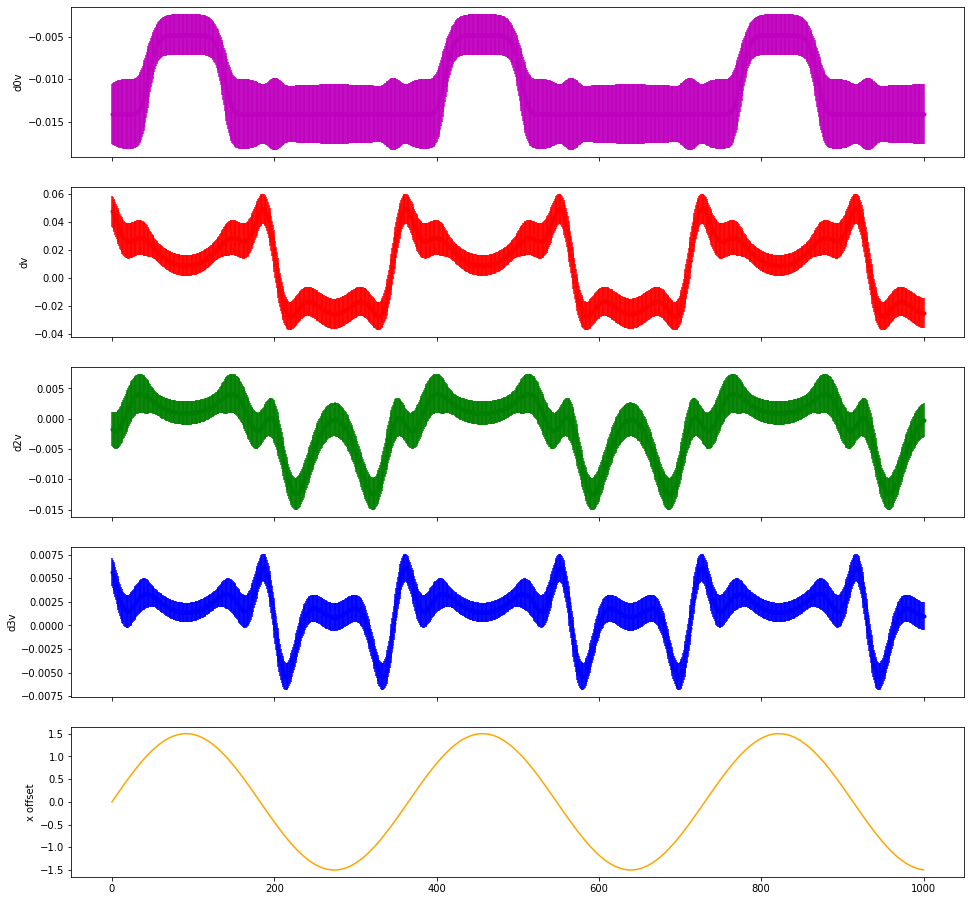

In [114]:
fig, ax = plt.subplots(5, 1, sharex='col', figsize=(16,16))

ax[0].errorbar(times, d0v, sd0v, fmt='m.')
ax[0].set_ylabel('d0v')

ax[1].errorbar(times, dv, sdv, fmt='r.')
ax[1].set_ylabel('dv')

ax[2].errorbar(times, d2v, sd2v, fmt='g.')
ax[2].set_ylabel('d2v')

ax[3].errorbar(times, d3v, sd3v, fmt='b.')
ax[3].set_ylabel('d3v')

ax[4].plot(times, xoff_serie, 'orange')
ax[4].set_ylabel('x offset')

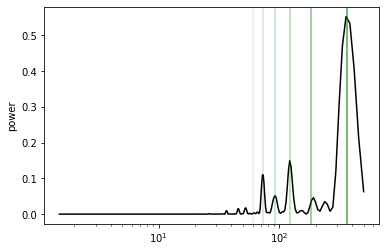

In [115]:
frequency, power = LombScargle(times, d2v, sd2v).autopower(minimum_frequency=1/500, maximum_frequency=1/1.5)
plt.plot(1/frequency, power, 'k')
plt.ylabel("power")
plt.xscale('log')
plt.axvline(365.25, color='g', alpha=0.7)
plt.axvline(365.25/2, color='g', alpha=0.5)
plt.axvline(365.25/3, color='g', alpha=0.3)
plt.axvline(365.25/4, color='g', alpha=0.25)
plt.axvline(365.25/5, color='g', alpha=0.2)
plt.axvline(365.25/6, color='g', alpha=0.1)
plt.savefig('line_contamination2.png')
plt.show()

# GIF !! 

In [31]:
import matplotlib.animation as animation

In [116]:
def line_contamination(i):
    plt.clf()
    a0 = 0.075
    sigma_0 = 0.1
    line = Template + Gauss(x+xoff_serie[i], a0, sigma_0) - 1
    a0 = 0.1
    sigma_0 = 0.15
    line = line + Gauss(x+xoff_serie[i]+1, a0, sigma_0) - 1
    
    plt.plot(x, line, 'k')

def dlw_impact(i):
    #generate line 
    a0 = 0.075
    sigma_0 = 0.1
    line = Template + Gauss(x+xoff_serie[i], a0, sigma_0) - 1
    a0 = 0.1
    sigma_0 = 0.15
    line = line + Gauss(x+xoff_serie[i]+1, a0, sigma_0) - 1
    #fit
    out = minimize(equation, params_ini, args = (d1, d2, d3, line-Template))
    
    d2v = out.params['d2v'].value
    sd2v= out.params['d2v'].stderr
    
    plt.errorbar(times[i], d2v, sd2v, fmt='ko')
    plt.ylabel('d2v')
    plt.xlim(0, 4*np.pi)

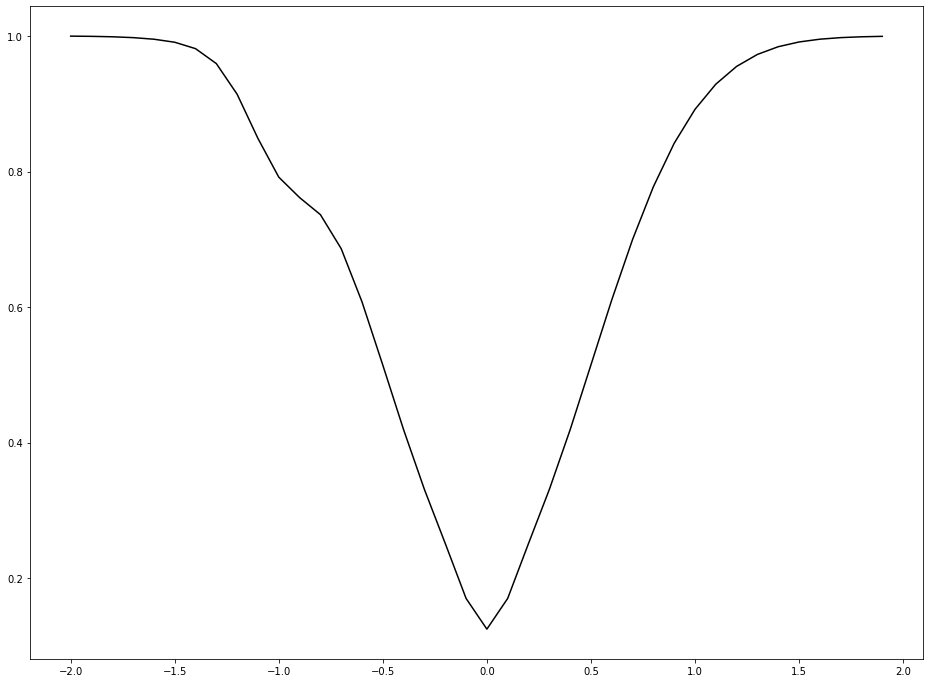

In [117]:
## Run Gif

times = np.linspace(0, 4*np.pi, 100) 
xoff_serie = 1.5 * np.sin(times)
#
fig = plt.figure(figsize=(16,12))
WOAWANIMTROBELLE = animation.FuncAnimation(fig, line_contamination, frames = np.arange(len(times)))#np.arange(len(times_tcorr)))
WOAWANIMTROBELLE.save('/home/paul/Bureau/IRAP/dLWPCA/line_contamination2.gif', writer=animation.PillowWriter(fps=24))
plt.show()

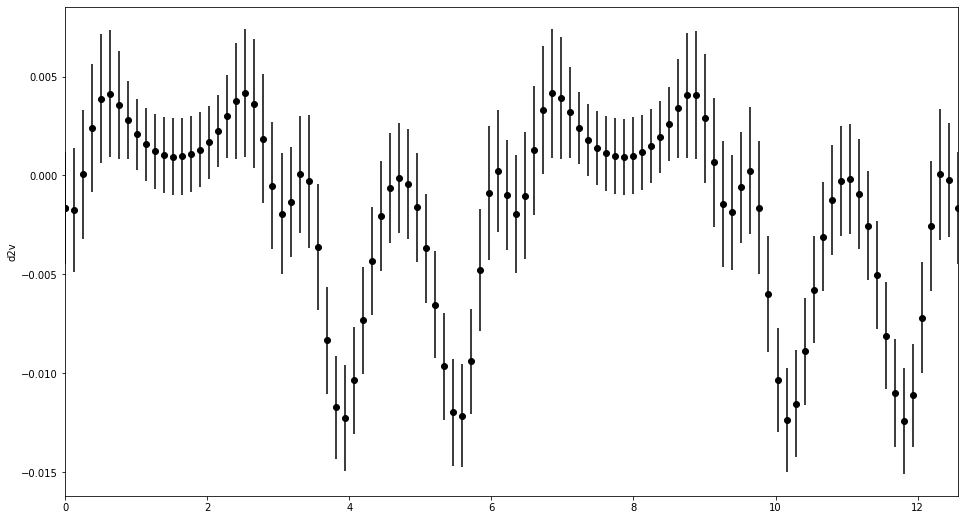

In [118]:
## Run Gif

times = np.linspace(0, 4*np.pi, 100) 
xoff_serie = 1.5 * np.sin(times)
#
fig = plt.figure(figsize=(16,9))
WOAWANIMTROBELLE = animation.FuncAnimation(fig, dlw_impact, frames = np.arange(len(times)))#np.arange(len(times_tcorr)))
WOAWANIMTROBELLE.save('/home/paul/Bureau/IRAP/dLWPCA/dlw_contamination2.gif', writer=animation.PillowWriter(fps=24))
plt.show()